In [1]:
# using Pkg
# Pkg.activate("..") 
# Pkg.instantiate()
using JPEC, Plots
gr() 

Plots.GRBackend()

In [2]:
using LinearAlgebra
using Printf
using Plots

### read Equil

In [3]:
# 1. Define the input parameters for the equilibrium solver.
#    - eq_filename: The name of the g-file we just created.
#    - eq_type: "efit" for a standard g-file.
#    - jac_type: "boozer" or "hamada" for the output coordinates.
#    - mpsi, mtheta: Resolution of the output grid.
equil_input = JPEC.Equilibrium.EquilInput(
    "beta_1.00",        # eq_filename
    "efit",          # eq_type
    "boozer",        # jac_type
    0.01,             # psilow
    1.0,             # psihigh
    100,             # mpsi (number of radial grid points)
    128              # mtheta (number of poloidal grid points)
)

# 2. Run the main equilibrium setup function.
#    This will read the file, solve the direct problem, and return the final object.
println("Starting equilibrium reconstruction...")
plasma_eq = JPEC.Equilibrium.setup_equilibrium(equil_input)
println("Equilibrium reconstruction complete.")

Starting equilibrium reconstruction...
--- Julia Equilibrium Setup ---
Equilibrium file: beta_1.00
Type = efit, Jac_type = boozer
----------------------------------------
--> Processing EFIT g-file: beta_1.00
--> Parsed from header: nw=129, nh=128
--> All main data blocks parsed successfully.
--> Creating 1D profile splines...
--> 1D Spline fitting complete.
--> Creating 2D psi spline...
--> 2D Spline fitting complete.
--- Starting Direct Equilibrium Processing ---
Finding magnetic axis...
  Iter  1: R = 3.115238, Z = 0.000008, |ΔR|=1.15e-01, |ΔZ|=1.11e-05
  Iter  2: R = 3.117635, Z = -0.000003, |ΔR|=2.40e-03, |ΔZ|=1.10e-05
  Iter  3: R = 3.117636, Z = -0.000003, |ΔR|=1.07e-06, |ΔZ|=1.04e-09
  Iter  4: R = 3.117636, Z = -0.000003, |ΔR|=2.12e-13, |ΔZ|=5.62e-16
Magnetic axis found at R=3.1176357129137466, Z=-2.9184696943092166e-6.
JPEC.SplinesMod.Helper.ReadOnlyArray{Float64, 1, Vector{Float64}}JPEC.SplinesMod.Helper.ReadOnlyArray{Float64, 1, Vector{Float64}}Array{Float64, 3}Finding inbo

### Use spline_eval 
sq!!

In [4]:
# The plasma_eq object contains the final 1D profile spline, `sq`.
# We will evaluate it on a fine grid to get smooth plot lines.
psi_norm_grid = range(0.0, 1.0, length=200)

# spline_eval returns the function values (and derivatives if requested).
# For sq, the quantities are: 1:F, 2:P*mu0, 3:Toroidal Flux, 4:q
f_profiles = JPEC.SplinesMod.spline_eval(plasma_eq.sq, collect(psi_norm_grid))

# Extract each profile into its own variable for clarity
F_profile      = f_profiles[:, 1]
P_profile      = f_profiles[:, 2]
tor_flux_prof  = f_profiles[:, 3]
q_profile      = f_profiles[:, 4];

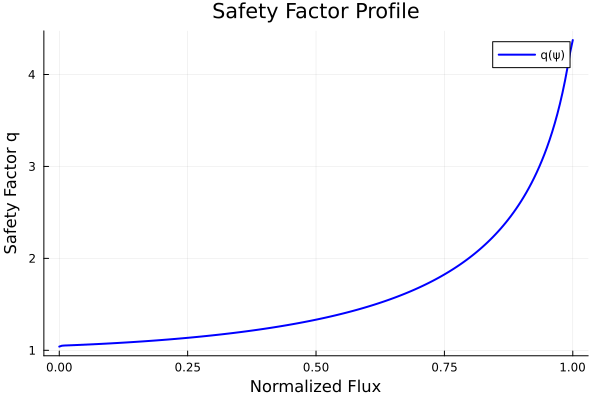

In [5]:
plot(psi_norm_grid, q_profile, 
     xlabel="Normalized Flux", ylabel="Safety Factor q", 
     title="Safety Factor Profile",
     legend=:topright, label="q(ψ)", lw=2, color=:blue)

In [ ]:
"""
    sing_find!(sing_surf_data, plasma_eq; mex=2, nn=1, itmax=200)

Finds and appends rational (singular) surfaces in a plasma equilibrium profile,
where `m = nn*q` within each interval between extrema of the safety factor profile `q(ψ)`.

The results are stored as `NamedTuple`s in the supplied vector `sing_surf_data`, 
with keys: `m`, `ψfac`, `ρ`, `q`, and `q1`.

# Arguments
- `sing_surf_data::Vector`: Container for output; will be emptied and updated in-place.
- `plasma_eq`: Plasma equilibrium object with a field `.sq` suitable for spline evaluation.
- `mex::Int`: Number of `q` profile extrema. Defaults to 2 (monotonic `q`).
- `nn::Int`: Toroidal mode number `n`.
- `itmax::Int`: Maximum allowed bisection iterations per root.

# Details
Searches each interval between adjacent `q`-profile extrema for all integer poloidal mode numbers `m`
that satisfy the rational surface condition `m = n*q(ψ)`, using bisection to find the roots.
Assumes a monotonic `q` profile, unless a generalized interface is implemented
(TODO: support for non-monotonic profiles).

# Output
For each rational surface found, a `NamedTuple` with:
- `m`: Poloidal mode number at this surface
- `ψfac`: Normalized flux label at the surface
- `ρ`: Square root of `ψfac`
- `q`: `q` value at the surface (`m/nn`)
- `q1`: Derivative of `q` at the surface

is pushed to `sing_surf_data`.
"""
function sing_find!(sing_surf_data, plasma_eq; nn=1, itmax=200)
    
    # Ensure sing_surf_data is empty before starting
    empty!(sing_surf_data)

    # Define functions to evaluate q and its first derivative
    qval(ψ) = JPEC.SplinesMod.spline_eval(plasma_eq.sq, ψ, 0)[4]
    q1val(ψ) = JPEC.SplinesMod.spline_eval(plasma_eq.sq, ψ, 1)[2][4] 

    # TODO: I assume monotonic here for checking, will need to provide some interface
    #  for the actual values fo (mex, qex) determined from the equil code
    qex = [qval(0.0), qval(1.0)]
    ψex = [0.0, 1.0]
    mex = 2

    # Loop over extrema of q, find all rational values in between
    for iex in 2:mex
        dq = qex[iex] - qex[iex-1]
        m = floor(Int, nn * qex[iex-1])
        if dq > 0
            m += 1
        end
        dm = Int(sign(dq * nn))

        # Loop over possible m's in interval
        while (m - nn * qex[iex-1]) * (m - nn * qex[iex]) <= 0
            it = 0
            ψ0 = ψex[iex-1]
            ψ1 = ψex[iex]
            ψfac = 0.0

            # Bisection method to find singular surface
            while it < itmax
                it += 1
                ψfac = (ψ0 + ψ1)/2
                singfac = (m - nn * qval(ψfac)) * dm
                if abs(singfac) <= 1e-12
                    break
                elseif singfac > 0
                    ψ0 = ψfac
                else
                    ψ1 = ψfac
                end
            end
            if it == itmax
                @warn "Bisection did not converge for m = $m"
                # You may want to continue, break, or error here
            else
                push!(sing_surf_data, (
                    m = m,
                    ψfac = ψfac,
                    ρ = sqrt(ψfac),
                    q = m / nn,
                    q1 = q1val(ψfac),
                ))
            end
            m += dm
        end
    end
end

sing_find!

In [8]:
sing_surf_data = []
sing_find!(sing_surf_data, plasma_eq)

In [17]:
sing_surf_data[1].ψfac

0.7971154589113212

In [ ]:
"""
    bubble!(key::AbstractVector, index::AbstractVector{Int}, mmin::Int, mmax::Int)

Sorts the indices in `index` in place such that `key[index[i]]` are in decreasing order
from `mmin` to `mmax` (inclusive).
"""
function bubble!(key::AbstractVector, index::AbstractVector{Int}, mmin::Int, mmax::Int)
    switched = true
    while switched
        switched = false
        for i in mmin:(mmax-1)
            if key[index[i]] < key[index[i+1]]
                index[i], index[i+1] = index[i+1], index[i]
                switched = true
            end
        end
    end
    return nothing
end

"""
    ode_axis_init(sing_surf_data, sq; nn = 1, ψlim = 0.9936, ψlow = 0.01, mlow = -12, mhigh = 20, singfac_min = 1e-5, qlow = 0.0, sort_type = "absm")

Initializes the ODE system near the magnetic axis for MHD or kinetic-MHD stability
analysis. This routine prepares solution vectors and sorting indices, locates
the relevant singular surfaces in the plasma equilibrium based on input data,
and sets integration boundaries and normalization factors for subsequent ODE integration
through singularities.

# Arguments
- `sing_surf_data`: Array of structures, each containing information about singular surfaces,
    including fields like `.ψfac`, `.q`, and `.q1`. Filled from sing_find function
- `sq`: Spline object controlling the equilibrium safety factor profile (typically contains equilibrium profile splines).

# Keyword Arguments (these are likely to be replaced by the user input file structure)
- `nn`: Integer. Toroidal mode number.
- `ψlim`: Float. Upper bound for normalized flux coordinate ψ.
- `ψlow`: Float. Lower bound for normalized flux coordinate ψ.
- `mlow`: Integer. Lowest poloidal mode number to consider.
- `mhigh`: Integer. Highest poloidal mode number to consider.
- `singfac_min`: Float. Minimum separation from a singular surface.
- `qlow`: Float. Lower bound for safety factor q. (Currently not implemented if > 0.)
- `sort_type`: String. Sorting criteria for mode numbers (`"absm"` for |m|, or
    `"sing"` for proximity to the first singular surface's m).

# Details
This function does the following:
- Determines relevant singular surfaces from the provided equilibrium/singularity data.
- Sets up arrays for the ODE solution and related workspaces for all poloidal harmonics in the range [`mlow`, `mhigh`].
- Sorts the initial harmonics according to the specified `sort_type`.
- Initializes normalization factors and solution arrays for use in the ODE integrator.
- Computes the initial offset (`singfac`) from the next singular surface.

Several features for kinetic MHD (indicated by `kin_flag`) or for `qlow > 0` are noted but not yet implemented.

"""

function ode_axis_init(sing_surf_data, plasma_eq; nn = 1, ψlim=0.9936, ψlow = 0.01, mlow = -12, mhigh = 20, singfac_min = 1e-5, qlow = 0.0, sort_type = "absm")
    # JMH - I think all default values here will be supplied by inputs
    # Right now, there are a lot of globals - not sure how we want to handle these
    # But at least the major outputs here match fortran dcon

    # maybe change how this is passed in? 
    qval(ψ) = JPEC.SplinesMod.spline_eval(plasma_eq.sq, ψ, 0)[4]
    q1val(ψ) = JPEC.SplinesMod.spline_eval(plasma_eq.sq, ψ, 1)[2][4] 

    # Preliminary computations
    new = true
    ix = 0
    psiout = 1.0
    ψfac = 0.0  # TODO: this was Fortran sq%xs(0)?
    msing = size(sing_surf_data)[1]
    
    # TODO: defined elsewhere
    mpert = mhigh - mlow + 1

    # Use Newton iteration to find starting psi if qlow is above q0
    # TODO: add this. For now, assume qlow = 0.0 and start at the first singular surface
    if qlow > 0.0
        @warn "qlow > 0.0 is not implemented in ode_axis_init"
    end

    # Find inner singular surface
    global ising = 0
    if false #(TODO: kin_flag)
        # for ising = 1:kmsing
        #     if kinsing[ising].psifac > psifac
        #         break
        #     end
        # end
    else
        for ising in 1:msing
            if sing_surf_data[ising].ψfac > ψfac
                break
            end
        end
    end
    ising = max(0, ising - 1)

    # Find next singular surface
    if false # TODO: (kin_flag)
        # while true
        #     ising += 1
        #     if ising > kmsing
        #         break
        #     end
        #     if psilim < kinsing[ising].psifac
        #         break
        #     end
        #     q = kinsing[ising].q
        #     if mlow <= nn * q && mhigh >= nn * q
        #         break
        #     end
        # end
        # if ising > kmsing || singfac_min == 0
        #     psimax = psilim * (1 - eps)
        #     next = "finish"
        # elseif psilim < kinsing[ising].psifac
        #     psimax = psilim * (1 - eps)
        #     next = "finish"
        # else
        #     psimax = kinsing[ising].psifac - singfac_min / abs(nn * kinsing[ising].q1)
        #     next = "cross"
        # end
    else
        while true
            ising += 1
            if ising > msing || ψlim < sing_surf_data[min(ising, msing)].ψfac
                break
            end
            q = sing_surf_data[ising].q
            if mlow <= nn * q && mhigh >= nn * q
                break
            end
        end
        if ising > msing || ψlim < sing_surf_data[min(ising, msing)].ψfac || singfac_min == 0
            ψmax = ψlim * (1 - eps)
            next = "finish"
        else
            ψmax = sing_surf_data[ising].ψfac - singfac_min / abs(nn * sing_surf_data[ising].q1)
            next = "cross"
        end
    end

    # Allocate and sort solutions by increasing value of |m-ms1|
    global u = zeros(ComplexF64, mpert, mpert, 2)
    global du = zeros(ComplexF64, mpert, mpert, 2)
    global u_save = zeros(ComplexF64, mpert, mpert, 2)
    global unorm0 = zeros(Float64, 2 * mpert)
    global unorm = zeros(Float64, 2 * mpert)
    global index = collect(1:mpert)
    m = mlow - 1 .+ index
    if sort_type == "absm"
        key = abs.(m)
    elseif sort_type == "sing"
        key = m
        if msing > 0
            key = key .- sing[1].m
        end
        key = -abs.(key)
    else
        error("Cannot recognize sort_type = $sort_type")
    end
    bubble!(key, index, 1, mpert) # in original Fortran: bubble(key, index, 1, mpert)
    println(key)
    println(index)

    # Initialize solutions
    u .= 0
    for ipert = 1:mpert
        u[index[ipert], ipert, 2] = 1
    end
    global msol = mpert
    global neq = 4 * mpert * msol
    u_save .= u
    global psi_save = ψfac

    # Initialize integrator parameters (JMH - not sure if these are needed in Julia)
    # global istep = 0
    # global iopt = 1
    # global itask = 5
    # global itol = 2
    # global mf = 10
    # global istate = 1

    # Compute conditions at next singular surface
    q = qval(ψlow) # Fortran: q=sq%fs(0,4)
    println(q)
    if false #TODO: (kin_flag)
        # if kmsing > 0
        #     m1 = round(Int, nn * kinsing[ising].q)
        # else
        #     m1 = round(Int, nn * qlim) + sign(one, nn * sq.fs1[mpsi, 5])
        # end
    else
        if msing > 0
            m1 = round(Int, nn * sing_surf_data[ising].q)
        else
            m1 = round(Int, nn * qlim) + sign(nn * q1val[end])
        end
    end
    global singfac = abs(m1 - nn * q)

    println(m1)
    println(singfac)

    # Set up work arrays (JMH - not sure if these are needed in Julia)
    # global liw = length(iwork)
    # global lrw = 22 + 64 * mpert * msol
    # global rwork = zeros(Float64, lrw)
    # global atol = zeros(ComplexF64, mpert, msol, 2)
    # global fixfac = zeros(ComplexF64, msol, msol)
    # iwork = 0
    # rwork = 0
    # rwork[1] = psimax
    # rwork[5] = psifac * 1e-3
    # rwork[11] = rwork[5]
end


ode_axis_init (generic function with 2 methods)

In [127]:
ode_axis_init(sing_surf_data, plasma_eq)

0
0.7971130892892229
cross
[12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[33, 32, 31, 30, 29, 28, 27, 26, 1, 25, 2, 24, 3, 23, 4, 22, 5, 21, 6, 20, 7, 19, 8, 18, 9, 17, 10, 16, 11, 15, 12, 14, 13]
1.0522385895980015
2
0.9477614104019985
